# Model Deployment

WHat is model deployment?

Model Deployment is the art of making your model(s) available for other people to use

## 0 Get Setup

In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1534/1534), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 4393 (delta 1457), reused 1401 (delta 1401), pack-reused 2859 (from 2)
Receiving objects: 100% (4393/4393), 650.71 MiB | 38.20 MiB/s, done.
Resolving deltas: 100% (2659/2659), done.
Updating files: 100% (248/248), done.


In [2]:
# setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 1 Get Data

The dataset we're going to use of this will be

Pizza Steak Sushi 20 percent

In [3]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [4]:
# Setup directory paths to train and test images
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

## 2 Food Vision Model Deployment Experiment Outline

Questions:
1. What is my most ideal machine learning model deployment scenario?
2. Where is my model going to go?
3. How is my model going to function?

**Food vision min ideal use case** - a model that works well and is fast

* Performs well - 95%+ accuracy
* Fast - as close to real time or faster (3 FPS+ or 30 ms)
  * Latency - time for predictions to take place

To try an achieve these goals, we will build 2 experiments
* EffNetb2 Feature Extractor
* VIT Feature Extractor

## 3 Creating an EffNetB2 Feature Extractor



In [5]:
# setup effnetb2 pretrained weights
import torchvision

# get effnetb2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# get the transforms
effnetb2_transforms = effnetb2_weights.transforms()

# Setup pretrained model instance
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# freeze base layers in the model
for param in effnetb2.parameters():
  param.requires_grad = False


Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 160MB/s]


In [6]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [7]:
set_seeds()
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=3 )
)

In [8]:
from torchinfo import summary
summary(effnetb2,
        input_size=(1,3,224,224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 3.1 Create a Function to create an Effnetb2 feature extractor

In [9]:
# create a function to create effentb2 and transforms
def create_effnetb2_model(num_classes: int = 3,
                          seed: int = 42
                          ):
  # create effnetb2 transforms, weights and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  # freeze all layers in the base model
  for param in model.parameters():
    param.requires_grad = False

  # Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=num_classes )
    )

  return model, transforms


In [10]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

In [11]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [12]:
summary(effnetb2,
        input_size=(1,3,224,224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 3.2 Create Datasets and DataLoaders for our Effntb2 Feature Extractor

In [13]:
from going_modular.going_modular import  data_setup, engine

In [14]:
effnet_train_dataloader, effnet_test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                             test_dir=test_dir,
                                                                                             transform = effnetb2_transforms,
                                                                                             batch_size = 32)


In [15]:
len(effnet_train_dataloader), len(effnet_test_dataloader), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 3.3 Training Effnetb2 Feature Extractor

In [16]:
# loss function
loss_effnet = nn.CrossEntropyLoss()

# optimizer
optimizer_effnet = torch.optim.Adam(params=effnetb2.parameters(),
                                    lr = 0.001)

# training function
set_seeds()
results_effnet = engine.train(model=effnetb2,
                              train_dataloader = effnet_train_dataloader,
                              test_dataloader = effnet_test_dataloader,
                              optimizer = optimizer_effnet,
                              loss_fn = loss_effnet,
                              epochs = 10,
                              device = device)




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9839 | train_acc: 0.5667 | test_loss: 0.7393 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7135 | train_acc: 0.8396 | test_loss: 0.5862 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5874 | train_acc: 0.8958 | test_loss: 0.4891 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4488 | train_acc: 0.9146 | test_loss: 0.4338 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4277 | train_acc: 0.9125 | test_loss: 0.3907 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4392 | train_acc: 0.8896 | test_loss: 0.3525 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4246 | train_acc: 0.8771 | test_loss: 0.3263 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3885 | train_acc: 0.8979 | test_loss: 0.3465 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3795 | train_acc: 0.8812 | test_loss: 0.3127 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3752 | train_acc: 0.8688 | test_loss: 0.2811 | test_acc: 0.9625


### 3.4 Inspecting Effnetb2 Loss curves

In [17]:
from helper_functions import plot_loss_curves

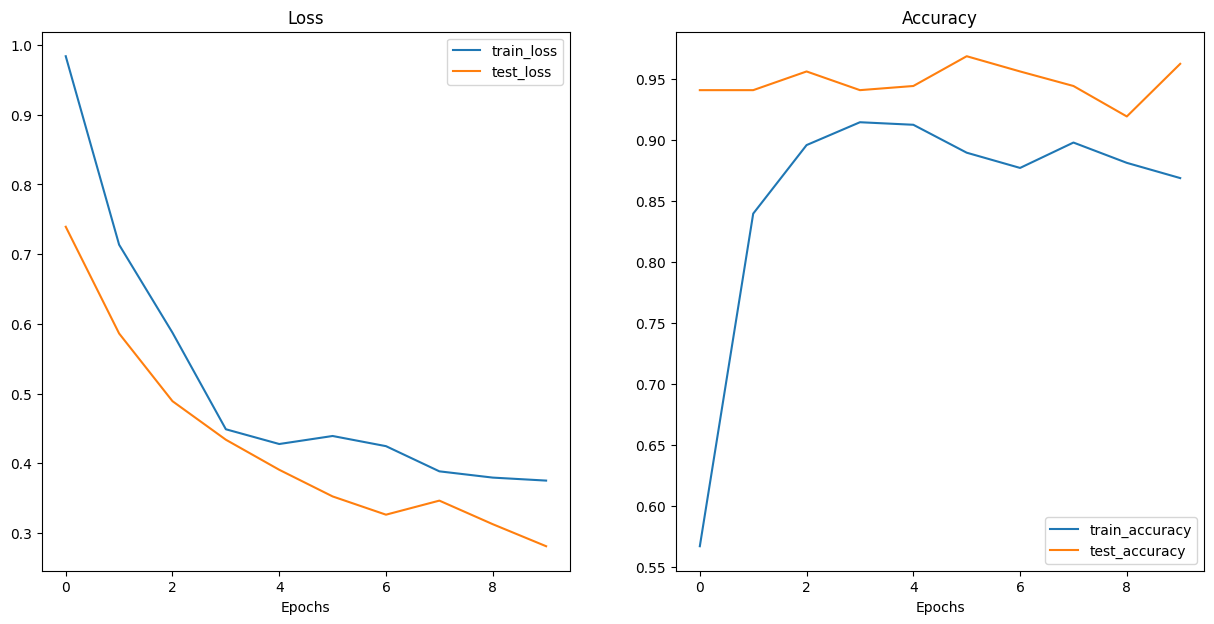

In [18]:
plot_loss_curves(results_effnet)

### 3.5 Saving Effnetb2 Feature Extractor to file

In [19]:
from going_modular.going_modular import utils

In [20]:
# save the model
utils.save_model(model=effnetb2,
                 target_dir = 'models',
                 model_name = 'pretrained_effnetb2_feature_extractor.pth')

[INFO] Saving model to: models/pretrained_effnetb2_feature_extractor.pth


### 3.6 Inspecting the size of our Effnetb2 Model

In [21]:
from pathlib import Path

# finding out the model size
effnetb2_size = Path('/content/models/pretrained_effnetb2_feature_extractor.pth').stat().st_size / (1024 * 1024)
print(f'Our EffnetB2 feature Extractor has a size of {effnetb2_size:.1f} MB')

Our EffnetB2 feature Extractor has a size of 29.8 MB


### 3.7 Collect our EffnetB2 Model stats


In [22]:
# count number of parrameters in EffnetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [23]:
# create a dictionary with Effneb2 Statistics
effnetb2_stats = {'test_loss': results_effnet['test_loss'][-1],
                  'test_acc': results_effnet['test_acc'][-1],
                  'number_of_params': effnetb2_total_params,
                  'model_size': effnetb2_size}

effnetb2_stats

{'test_loss': 0.2810868382453918,
 'test_acc': 0.9625,
 'number_of_params': 7705221,
 'model_size': 29.84014320373535}

## 4 Creating a VIT Feature Extractor

In [24]:
# check out the VIT heads layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [25]:
def create_vit_model(num_classes: int = 3,
                     seed:int = 42):
  # create effnetb2 transforms, weights and model
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights=weights)

  # freeze all layers in the base model
  for param in model.parameters():
    param.requires_grad = False

  # Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.heads = nn.Sequential(
    nn.Linear(in_features=768, out_features=num_classes )
    )

  return model, transforms



In [26]:
vit, vit_transforms = create_vit_model()

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 184MB/s]


In [27]:
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [28]:
summary(vit,
        input_size=(1,3,224,224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 4.1 Create Dataloaders for our VIT Feature Extractor

In [29]:
vit_train_dataloader, vit_test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir = test_dir,
                                                                                       transform = vit_transforms,
                                                                                       batch_size = 32)

len(vit_train_dataloader), len(vit_test_dataloader), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 4.2 Training our VIT Feature Extractor

In [30]:
# loss function
vit_loss_fn = nn.CrossEntropyLoss()

# setup potimizer
vit_optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr = 1e-3)


# train model
vit_results = engine.train(model = vit,
                           train_dataloader = vit_train_dataloader,
                           test_dataloader = vit_test_dataloader,
                           optimizer = vit_optimizer,
                           loss_fn = vit_loss_fn,
                           epochs = 10,
                           device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6173 | train_acc: 0.7854 | test_loss: 0.2692 | test_acc: 0.9352
Epoch: 2 | train_loss: 0.2241 | train_acc: 0.9437 | test_loss: 0.1414 | test_acc: 0.9631
Epoch: 3 | train_loss: 0.1539 | train_acc: 0.9563 | test_loss: 0.1071 | test_acc: 0.9722
Epoch: 4 | train_loss: 0.1412 | train_acc: 0.9625 | test_loss: 0.0966 | test_acc: 0.9693
Epoch: 5 | train_loss: 0.1058 | train_acc: 0.9667 | test_loss: 0.0866 | test_acc: 0.9722
Epoch: 6 | train_loss: 0.0903 | train_acc: 0.9729 | test_loss: 0.0823 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0783 | train_acc: 0.9792 | test_loss: 0.0772 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0693 | train_acc: 0.9792 | test_loss: 0.0712 | test_acc: 0.9784
Epoch: 9 | train_loss: 0.0615 | train_acc: 0.9896 | test_loss: 0.0705 | test_acc: 0.9722
Epoch: 10 | train_loss: 0.0548 | train_acc: 0.9938 | test_loss: 0.0667 | test_acc: 0.9722


### 4.3 Plot Loss Curves for VIT Feature Extractor

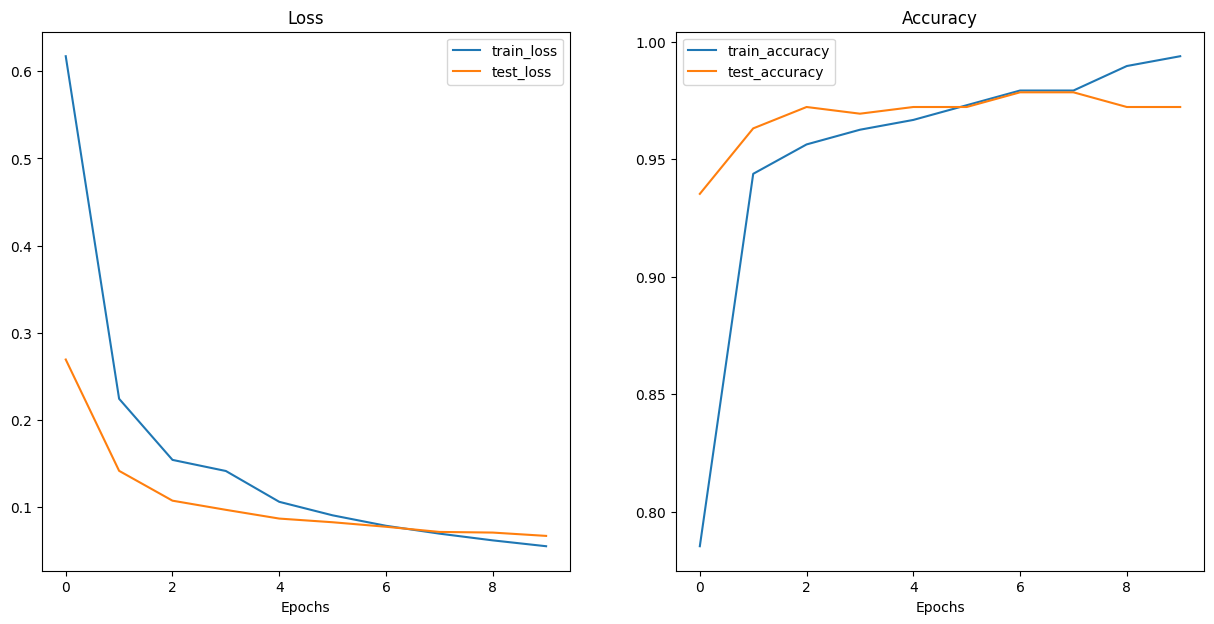

In [31]:
plot_loss_curves(vit_results)

### 4.4 Saving IT Feature Extractor

In [32]:
# save model
utils.save_model(model = vit,
                 target_dir = 'models',
                 model_name = '09_pretrained_vit_feature_extractor.pth')

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor.pth


### 4.5 Check the size of our VIT Feature Extractor

In [33]:
from pathlib import Path

# get file size in MB
pretrained_vit_model_size = Path('/content/models/09_pretrained_vit_feature_extractor.pth').stat().st_size / (1024 * 1024)
print(f'VIT feature extractor is {pretrained_vit_model_size:.2f} MB')

VIT feature extractor is 327.37 MB


### 4.6 Collecting Statistics from our VIT Feature Extractor

In [34]:
# count number of parameters in VIT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [35]:
# create a vit stats dictionary
vit_stats = {
    'test_loss': vit_results['test_loss'][-1],
    'test_acc': vit_results['test_acc'][-1],
    'number_of_params': vit_total_params,
    'model_size': pretrained_vit_model_size
}

vit_stats

{'test_loss': 0.06667962307110428,
 'test_acc': 0.972159090909091,
 'number_of_params': 85800963,
 'model_size': 327.3664722442627}

## 5 Making predictions with our trained model and timing

Our goal
1. perfomr well (95%+ acc)
2. fast (at least 30 fps)

To test criteria two:
1. loop through test images
2. time how long each model takes to make a prediction on the images

Let's work towards making afunction called `pred_and_store()`to do so

We'll need a list of image paths first


In [36]:
from pathlib import Path

# get all test data paths
test_data_paths = list(Path(test_dir).glob('*/*.jpg'))
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3497151.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/476421.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2250611.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2572488.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3486640.jpg')]

### 5.1 Create a function to make predictions across the test dataset

Steps to create `pred_and_store()`:
1. Create a function that takes a list of paths, a trained pytorch model and a series of transforms and list of target classses and a device
2. create an empty list to return a ful list of predictions
3. loop through the target input paths
4. create an empty dictionary fr each sample (prediction statistics go in here)
5. Get the sample path and ground truth from the filepath
6. start the predicition timer
7. Open the image using `PIL.Image.open(path)`
8. transform the image to be used with model
9. prepare the model for inference
and turning on eval mode
10. Turn on `torch.inference_mode()` and pass te target transformed image to the model and perform a forward pass + calculate a pred prob + class pred class
11. Add the pred prob + pred class to the dictionary
12. End the prediction timer and add the time to the prediction dictionary
13. See if the if predicied class matches the ground truth
14. Append the updated prediction dictionary to the list created in step 2
15. return the listdef pred_and




In [37]:
from typing import List, Dict
from timeit import default_timer as timer
from PIL import Image
from tqdm.auto import tqdm
import pathlib
import torch

# 1. create function
def pred_and_store(model: torch.nn.Module,
                   path_list: List[pathlib.Path],
                   transforms: torchvision.transforms,
                   class_names: List[str],
                   device: str = device) -> List[Dict]:

  # 2. create empty list
  pred_list = []

  # 3.loop through target path_list
  for path in tqdm(path_list):
    # 4. create empt dictionary
    pred_dict = {}

    # 5. get the sample path and grond troth label
    ground_truth_label = path.parent.stem

    # 6 start prediction timer
    pred_start_time = timer()

    # 7 Open the image
    img = Image.open(path)

    # 8 transfomr the image
    transformed_img = transforms(img).unsqueeze(0).to(device)

    # 9 Prep model for eval model
    model.to(device)
    model.eval()

    # 10 turn on inferrnence mode
    with torch.inference_mode():
      logits = model(transformed_img)
      pred_probs = torch.softmax(logits, dim =1)
      pred_class = pred_probs.argmax(dim=1)
      label = class_names[pred_class.cpu()]

      #11 add pred probs and pred class to he dictionary
      pred_dict['image_path'] = path
      pred_dict['ground_truth'] = ground_truth_label
      pred_dict['pred_probs'] = round(pred_probs.unsqueeze(0).max().cpu().item(), 4)
      pred_dict['pred_class'] = pred_class.cpu().item()
      pred_dict['pred_label'] = label

      # 12 end the pred timer
      pred_end_time = timer()
      pred_dict['pred_time'] = round(pred_end_time - pred_start_time, 4)

    # 13 see if prediciton matches ground truth
    pred_dict['correct_pred'] = ground_truth_label == label

    # 14 Append dictionary to list
    pred_list.append(pred_dict)


  return pred_list

### 5.2 Making an timing prediction with EffnetB2

Things to note:
1. Device - we're going to code our predictions to happen on CPU
2. Transforms - we want to make sure each of the models are predicitng on images that have been prepared with the appropriate transforms

In [38]:


effnetb2_preds_list = pred_and_store(model=effnetb2,
               path_list=test_data_paths,
               transforms=effnetb2_transforms,
               class_names = class_names,
               device='cpu')

effnetb2_preds_list[:2]

  0%|          | 0/150 [00:00<?, ?it/s]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3497151.jpg'),
  'ground_truth': 'pizza',
  'pred_probs': 0.9874,
  'pred_class': 0,
  'pred_label': 'pizza',
  'pred_time': 0.3018,
  'correct_pred': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/476421.jpg'),
  'ground_truth': 'pizza',
  'pred_probs': 0.6586,
  'pred_class': 0,
  'pred_label': 'pizza',
  'pred_time': 0.1209,
  'correct_pred': True}]

In [39]:
# turn the test pred dict into a datafrme
import pandas as pd
effnetb2_preds_df = pd.DataFrame(effnetb2_preds_list)
effnetb2_preds_df.head()

,image_path,ground_truth,pred_probs,pred_class,pred_label,pred_time,correct_pred
0,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9874,0,pizza,0.3018,True
1,data/pizza_steak_sushi_20_percent/test/pizza/4...,pizza,0.6586,0,pizza,0.1209,True
2,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.8142,0,pizza,0.1268,True
3,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.9146,0,pizza,0.1644,True
4,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9740,0,pizza,0.1425,True


In [40]:
# check the number f correct predictions
effnetb2_preds_df.correct_pred.value_counts()

,count
correct_pred,
True,144
False,6


In [41]:
# find the average tie per predicition
effnetb2_avg_time_per_pred = round(effnetb2_preds_df.pred_time.mean(), 4)
print(f'Average time for predicition {effnetb2_avg_time_per_pred}')

Average time for predicition 0.1074


### 5.3 Making and timing predictions with our VIT Feature Extractor

In [42]:
# make list of prediciton dictionaries with VIT on test images

vit_preds_list = pred_and_store(model=vit,
                                path_list=test_data_paths,
                                transforms=vit_transforms,
                                class_names=class_names,
                                device = 'cpu')

vit_preds_list[:2]

  0%|          | 0/150 [00:00<?, ?it/s]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3497151.jpg'),
  'ground_truth': 'pizza',
  'pred_probs': 0.9953,
  'pred_class': 0,
  'pred_label': 'pizza',
  'pred_time': 0.5255,
  'correct_pred': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/476421.jpg'),
  'ground_truth': 'pizza',
  'pred_probs': 0.9865,
  'pred_class': 0,
  'pred_label': 'pizza',
  'pred_time': 0.3876,
  'correct_pred': True}]

In [43]:
vit_test_pred_df = pd.DataFrame(vit_preds_list)
vit_test_pred_df.head()

,image_path,ground_truth,pred_probs,pred_class,pred_label,pred_time,correct_pred
0,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9953,0,pizza,0.5255,True
1,data/pizza_steak_sushi_20_percent/test/pizza/4...,pizza,0.9865,0,pizza,0.3876,True
2,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.9987,0,pizza,0.3721,True
3,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.9980,0,pizza,0.3851,True
4,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9968,0,pizza,0.3855,True


In [44]:
vit_test_pred_df.correct_pred.value_counts()

,count
correct_pred,
True,146
False,4


In [45]:
# find the average time per prediciton
vit_avg_time_per_pred = round(vit_test_pred_df.pred_time.mean(), 4)
print(f'Average time per predicition is {vit_avg_time_per_pred} secs')

Average time per predicition is 0.3971 secs


In [46]:
# append avg time pre prediction to Vit stats
vit_stats['time_per_pred_cpu'] = vit_avg_time_per_pred

# append avg time pre prediction to effnetb2 stats
effnetb2_stats['time_per_pred_cpu'] = effnetb2_avg_time_per_pred

## Comparing Model results, prediction times and size

In [47]:
# turn stats dict in a DataFarme
df = pd.DataFrame([effnetb2_stats, vit_stats])

# add column for for model names
df['model'] = ['EffnetB2', 'VIT']

# make acc into %
df['test_acc'] = round(df['test_acc'] * 100, 2)

df

,test_loss,test_acc,number_of_params,model_size,time_per_pred_cpu,model
0,0.281087,96.25,7705221,29.840143,0.1074,EffnetB2
1,0.066680,97.22,85800963,327.366472,0.3971,VIT


In [48]:
# compare vit to effnetb2 across the characteristics
pd.DataFrame(data = df.set_index('model').loc['VIT'] / df.set_index('model').loc['EffnetB2'],
             columns=['VIT to Effnet ratios']).T

,test_loss,test_acc,number_of_params,model_size,time_per_pred_cpu
VIT to Effnet ratios,0.237221,1.010078,11.135432,10.970674,3.697393


### 6.1 Visualizing the speed vs performance trade off

We've compare our EffEnt and Vit models, let's visualize the comparison between the two with a speed vs performace plot

We'll do so with matplotlib
1. create a scatter plot from the comparison DataFrame to compare EffNetB2 and VIT across test acc and pred time
2. add title and labels
3. annotate the samples on the scatter plot
4. create a legend based on the model sizes

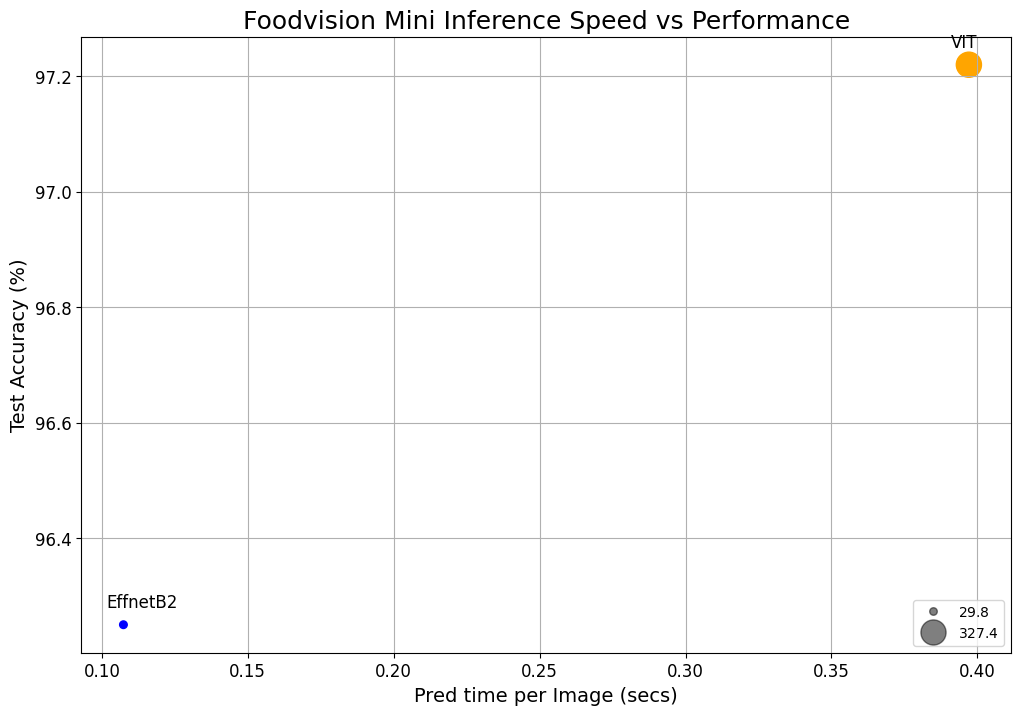

In [49]:
# 1 create a plot from model cmpare dataFarme
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (12, 8))
scatter = ax.scatter(data=df,
                     x = 'time_per_pred_cpu',
                     y = 'test_acc',
                     c = ['blue', 'orange'],
                     s = 'model_size')

# 2 add titles and labels
ax.set_title('Foodvision Mini Inference Speed vs Performance',
             fontsize = 18)
ax.set_xlabel('Pred time per Image (secs)', fontsize = 14)
ax.set_ylabel('Test Accuracy (%)', fontsize = 14)
ax.tick_params(axis='both', labelsize = 12)
ax.grid(True)

# 3 annotate the samples n the plot
for index, row in df.iterrows():
  ax.annotate(text=row['model'],
              xy = (row['time_per_pred_cpu'] - 0.006, row['test_acc'] + 0.03),
              size =12)

# 4 create a legend on the model size
handles, labels = scatter.legend_elements(prop='sizes', alpha = 0.5)
model_size_legend = ax.legend(handles, labels, loc = 'lower right')

## 7. Bringing Foodvision to life by creating a Gradio Demo

We've chosen to deploy Effnet as it fullfills our criteria the best

What is Gradio - the fastest way to demo your ML model with a friendly web interface so anyone can use it

In [50]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 132.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.6 MB/s eta 0:00:00
Gradio version: 5.29.0


### 7.1 Gradio Overview

Gradio helpscreate ML demo

Why create a demo

So other people can try our models and we can test them in the real world

Deployment is as important as training

The overall premise of Gradio is to map inputs -> functions/models -> outputs

### 7.2 Create a fnunction to map our inputs and outputs

In [51]:
## put model on cpu
effnetb2 = effnetb2.to('cpu')

# check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

Let's create a function called `predict()` to go from:

```
images of food -> ML model EffnetB2 -> output (fod class label)
```

In [52]:
from typing import Tuple, Dict
from timeit import default_timer as timer

def predict(img) -> Tuple[Dict, float]:
  # start a timer
  start_time = timer()

  # transform the input image
  transformed_img = effnetb2_transforms(img).unsqueeze(0).to('cpu')

  # Put model into eval mode, make prediciton
  effnetb2.eval()
  with torch.inference_mode():
    logits = effnetb2(transformed_img)
    pred_probs = torch.softmax(logits, dim=1)[0]

  # Create prediciton label and prediction probability dictionary
  pred_label_and_probs = {}
  for idx in range(len(class_names)):
    pred_label_and_probs[class_names[idx]] = float(pred_probs[idx])

  # calculate the pred time
  end_time = timer()
  pred_time = round(end_time - start_time, 4)

  # return pred dict and pred time

  return pred_label_and_probs, pred_time



In [53]:
import random
from PIL import Image

# get a list of all test image paths
test_data_paths = list(Path(test_dir).glob('*/*.jpg'))

# Random image
random_image_path = random.sample(test_data_paths, k=1)[0]

# open target image
image = Image.open(random_image_path)
print(f'[INFO] Predicting on image at path: {random_image_path}\n')

# predict on image and print out outputs
pred_dict, pred_time = predict(image)
print(pred_dict)
print(pred_time)

[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/pizza/1687143.jpg

{'pizza': 0.9210524559020996, 'steak': 0.045085810124874115, 'sushi': 0.03386175259947777}
0.1038


### 7.3 Creating a list of Example Images



In [54]:
# ceate a list of example inputs to our Gradio Demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3 )]
example_list

[['data/pizza_steak_sushi_20_percent/test/sushi/3365273.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/2752603.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/2398925.jpg']]

### 7.4 Building a Gradio Interface

```
input: image -> transform -> predict with EffnetB2 -> output: pred, pred_prob, time
```


In [55]:
import gradio as gr

# create title, description and article
title = 'Foodvision Mini 🍕 🥩 🍣'
description = ' An EfficientNet computervision model to classify images as pizza, steak or sushi'
article = 'Created at 09. PyTorch Model Deployment'

# create the gradio demo
demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type='pil'),
                    outputs=[gr.Label(num_top_classes=3, label = 'Predictions'),
                             gr.Number(label='Prediction Time (secs)')],
                    examples = example_list,
                    title=title,
                    description=description,
                    article=article)

# launch the demo
demo.launch(debug=False, # print errors locally
            share=True) # generate a publicly shareable URL

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2d39ca4e6e0a2b299e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## 8 Turning our FoodVision Min Gradio Demo into a Deployable App

Our Gradio demo from colab are fantastic but they expire quickly

To fix this, we will prepare our app files to host them on Hugging Face Spaces

### 8.1 Hugging Face Spaces

> Hugging Face Spacees offers a simple way to host ML dmo apps directly on your profile or your organization's profile

If github is aplace to show your coding skills, Hugging Fac Spaces is a place to showcase your ML skills through sharing ML demos that you've built

### 8.2 Deployed Gradio App Structure

Let's start to put all our app files into a single directory

```
Colab -> Folder with all Gradio Files -> upload app files to Hugging Face Spaces -> Deploy

```

By the end, our file structure will look like this

```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```

You can see this in action as
* a deployed app


### 8.3 Create a `Demos` folder to store our FoodVision App files

In [56]:
import shutil
from pathlib import Path

# create FoodVision Minin demo path
foodvision_mini_demo_path = Path('demos/foodvision_mini')

# remove files that already exisit and create ne deirectory
if foodvision_mini_demo_path.exists():
  shutil.rmtree(foodvision_mini_demo_path)
  foodvision_mini_demo_path.mkdir(parents=True,
                                  exist_ok=True)
else:
  foodvision_mini_demo_path.mkdir(parents=True,
                                  exist_ok=True)



### 8.4 Creating a Folder of example images to use with our Foodvsion demo

Want we want:
* 3 images in our examples directory
* examles from the test dataset

In [57]:
import shutil
from pathlib import Path

# create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / 'examples'
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# collect tree random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# copy the three images to the examples directory
for example in foodvision_mini_examples:
  destination = foodvision_mini_examples_path / example.name
  print(f'[INFO] copying {example} to {destination}')
  shutil.copy2(src=example,
               dst=destination)

[INFO] copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
[INFO] copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg
[INFO] copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg


Let's verify that we can get a list of lists from our `examples` directory

In [58]:
import os

# get examplee files into a list of lists
example_list = [['examples/' + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/3622237.jpg'], ['examples/592799.jpg'], ['examples/2582289.jpg']]

### 8.5 Moving Our trained EfnetB2 model to our Foodvision Mini Demo Directory

In [59]:
import shutil

# create a source path for our model
effnetb2_model_path = '/content/models/pretrained_effnetb2_feature_extractor.pth'

# create a destination path
effnetb2_model_dest_path = foodvision_mini_demo_path / effnetb2_model_path.split('/')[-1]

# try to move the model file
try:
  print(f'[INFO] attemping to move {effnetb2_model_path} to {effnetb2_model_dest_path}')

  # move the model
  shutil.move(src=effnetb2_model_path,
              dst=effnetb2_model_dest_path)

  print(f'[INFO] model move complete')

# if model has been moved check if it exist
except:
  print(f'[INFO] No model found at {effnetb2_model_path} perhaps it has already been moved')
  print(f'[INFO] model exists at {effnetb2_model_dest_path}: {effnetb2_model_dest_path.exists()}')

[INFO] attemping to move /content/models/pretrained_effnetb2_feature_extractor.pth to demos/foodvision_mini/pretrained_effnetb2_feature_extractor.pth
[INFO] model move complete


### 8.6 Turning our Effnetb2 Model Creation Function into a python script

In [60]:
%%writefile demos/foodvision_mini/model.py

import torch
import torchvision

from torch import nn

# create a function to create effentb2 and transforms
def create_effnetb2_model(num_classes: int = 3,
                          seed: int = 42
                          ):
  # create effnetb2 transforms, weights and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  # freeze all layers in the base model
  for param in model.parameters():
    param.requires_grad = False

  # Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=num_classes )
    )

  return model, transforms




Writing demos/foodvision_mini/model.py


### 8.7 Turing our Food Vision Demo App into a Python script

The file wit have four major parts
1. imports and class names
2. model and transforms preparation
3. predict function `predict()`
4. gradio app -> our interface + launch command

In [61]:
%%writefile demos/foodvision_mini/app.py

import gradio as gr
import os
import torch
from typing import Tuple, Dict
from timeit import default_timer as timer
from model import create_effnetb2_model

### Setup class names
class_names = ['pizza', 'steak', 'sushi']

### get the model and transforms
effnetb2, effnetb2_transforms = create_effnetb2_model()

### Load Saved weights
effnetb2.load_state_dict(
    torch.load(f='pretrained_effnetb2_feature_extractor.pth',
               map_location=torch.device('cpu')) # load model to the cpu
)

### Prediction Function
def predict(img) -> Tuple[Dict, float]:
  # start a timer
  start_time = timer()

  # transform the input image
  transformed_img = effnetb2_transforms(img).unsqueeze(0).to('cpu')

  # Put model into eval mode, make prediciton
  effnetb2.eval()
  with torch.inference_mode():
    logits = effnetb2(transformed_img)
    pred_probs = torch.softmax(logits, dim=1)[0]

  # Create prediciton label and prediction probability dictionary
  pred_label_and_probs = {}
  for idx in range(len(class_names)):
    pred_label_and_probs[class_names[idx]] = float(pred_probs[idx])

  # calculate the pred time
  end_time = timer()
  pred_time = round(end_time - start_time, 4)

  # return pred dict and pred time

  return pred_label_and_probs, pred_time

### gradio app
# create title, description and article
title = 'Foodvision Mini 🍕 🥩 🍣'
description = ' An EfficientNet computervision model to classify images as pizza, steak or sushi'
article = 'Created at 09. PyTorch Model Deployment'

example_list = [[example] for example in os.listdir('examples')]

# create the gradio demo
demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type='pil'),
                    outputs=[gr.Label(num_top_classes=3, label = 'Predictions'),
                             gr.Number(label='Prediction Time (secs)')],
                    examples = example_list,
                    title=title,
                    description=description,
                    article=article)

# launch the demo
demo.launch(debug=False, # print errors locally
            share=True) # generate a publicly shareable URL

Writing demos/foodvision_mini/app.py


### 8.8 Creating `requirements.txt` file

The requirements file will tell our Hugging face Space what dependiencies we will need

We will need

1. torch
2. torchvision
3. gradio

In [62]:
%%writefile demos/foodvision_mini/requirements.txt
torch==2.6.0
torchvision==0.21.0
gradio==5.27.0

Writing demos/foodvision_mini/requirements.txt


## 9 Deploying our FoodVision App to Hugging Face

### 9.1 Downloading our Foodvision mini App files

We want to download our foodvision app files so we can upload them to Hugging Face Spaces

In [63]:
!ls demos/foodvision_mini

app.py	  model.py				     requirements.txt
examples  pretrained_effnetb2_feature_extractor.pth


In [64]:
# change into the foodvision min directory and zip it rom the inside
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: app.py (deflated 54%)
  adding: examples/ (stored 0%)
  adding: examples/3622237.jpg (deflated 0%)
  adding: examples/592799.jpg (deflated 1%)
  adding: examples/2582289.jpg (deflated 17%)
  adding: model.py (deflated 50%)
  adding: pretrained_effnetb2_feature_extractor.pth (deflated 8%)
  adding: requirements.txt (deflated 6%)


In [65]:
# download
try:
  from google.colab import files
  files.download('demos/foodvision_mini.zip')
except:
  print('Not running in colab. Please download manually')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 9.2 Running our Demo App Locally

### 9.3 Uploading our Foodvision mini Gradio App to Hugging Face Spaces

See the steps here:
https://www.learnpytorch.io/09_pytorch_model_deployment/#93-uploading-to-hugging-face

## 10 Foodvision Big!!!

Foodvision min works well with pizza, steak and sushi.

Let's step things up and use Foodvision Big to classify 101 food classes

### 10.1 Create a model for foodvision big and


In [66]:
# create food101 and transform
effnet_b2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

In [67]:
summary(effnet_b2_food101,
        input_size=(1,3,224,224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

Since we're working with a larger dataset, we want to introdue some data augmentation techniques

* With larger datasets and larger models, overfitting becomes more of a problem
* let's use TrivialAugment as our data augmentation technique

In [68]:
food_101_train_transforms = torchvision.transforms.Compose([torchvision.transforms.TrivialAugmentWide(),
                                                      effnetb2_transforms])
food_101_train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

### 10.2 Getting Data for foddvision big

In [69]:
from torchvision import datasets

# setup data directory
from pathlib import Path
data_dir = Path('data')

# get the training data
train_data = datasets.Food101(root= data_dir,
                              split='train',
                              transform=food_101_train_transforms,
                              download=True)

# get the test data
test_data = datasets.Food101(root= data_dir,
                              split='test',
                              transform=effnetb2_transforms,
                              download=True)

100%|██████████| 5.00G/5.00G [01:06<00:00, 74.7MB/s]


In [70]:
# get Food101 class names
food101_class_names = train_data.classes

# view the first 10
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### 10.1 Creatigna subset of the Food101 dataset for faster experimentation

Why create a subset?

We want our set of experiments to run as quickly as possible

Foodvision mini works prety well but this is the first time we've upgraded to 101 classes

To do so, lets make a subset of 20% of the data from the Food101 dataset

We want to beat the original accuracy on the food101 datasets of 56%

In [71]:
from torch.utils.data import random_split

def split_dataset(dataset: torchvision.datasets,
                  split_size: float = 0.2,
                  seed: int = 42):
  # create split lengths
  length_1 = int(len(dataset)* split_size)
  lenght_2 = len(dataset) - length_1

  # print out info
  print(f'[INFO] splitting dataset of dataset of length {len(dataset)} into splits of size {length_1} and {lenght_2}')

  # create splits with random seed
  random_split_1, rnadom_split_2 = random_split(dataset,
                                                lengths=[length_1,lenght_2],
                                                generator=torch.manual_seed(seed))
  return random_split_1, rnadom_split_2

In [72]:
# create training 20% split
train_split_food101_20_percent, _ = split_dataset(train_data,
                                                  split_size=0.2)

# create testing 20% split
test_split_food101_20_percent, _ = split_dataset(test_data,
                                                  split_size=0.2)


[INFO] splitting dataset of dataset of length 75750 into splits of size 15150 and 60600
[INFO] splitting dataset of dataset of length 25250 into splits of size 5050 and 20200


In [73]:
len(train_split_food101_20_percent), len(test_split_food101_20_percent)

(15150, 5050)

### 10.4 Turning our datasets into dataloaders

In [74]:
from torch.utils.data import DataLoader
import os

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_food101_20_percent = DataLoader(dataset=train_split_food101_20_percent,
                                                  batch_size=BATCH_SIZE,
                                                  num_workers=NUM_WORKERS,
                                                  shuffle=True)

test_dataloader_food101_20_percent = DataLoader(dataset=test_split_food101_20_percent,
                                                batch_size=BATCH_SIZE,
                                                num_workers=NUM_WORKERS,
                                                shuffle=False)

In [75]:
len(train_dataloader_food101_20_percent), len(test_dataloader_food101_20_percent)

(474, 158)

### 10.5 Training FoodVision Big

In [76]:
from going_modular.going_modular.engine import train

In [77]:
# setup loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing = 0.1)

# set optimizer
optimizer = torch.optim.Adam(params=effnet_b2_food101.parameters(),
                             lr = 0.001)


food101_results = train(model=effnet_b2_food101,
                        train_dataloader = train_dataloader_food101_20_percent,
                        test_dataloader = test_dataloader_food101_20_percent,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = 5,
                        device = device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6397 | train_acc: 0.2818 | test_loss: 2.8052 | test_acc: 0.4865
Epoch: 2 | train_loss: 2.8642 | train_acc: 0.4367 | test_loss: 2.4605 | test_acc: 0.5455
Epoch: 3 | train_loss: 2.6490 | train_acc: 0.4860 | test_loss: 2.3630 | test_acc: 0.5547
Epoch: 4 | train_loss: 2.5493 | train_acc: 0.5063 | test_loss: 2.3109 | test_acc: 0.5715
Epoch: 5 | train_loss: 2.5000 | train_acc: 0.5236 | test_loss: 2.2746 | test_acc: 0.5852


### 10.6 inpect the loss curve


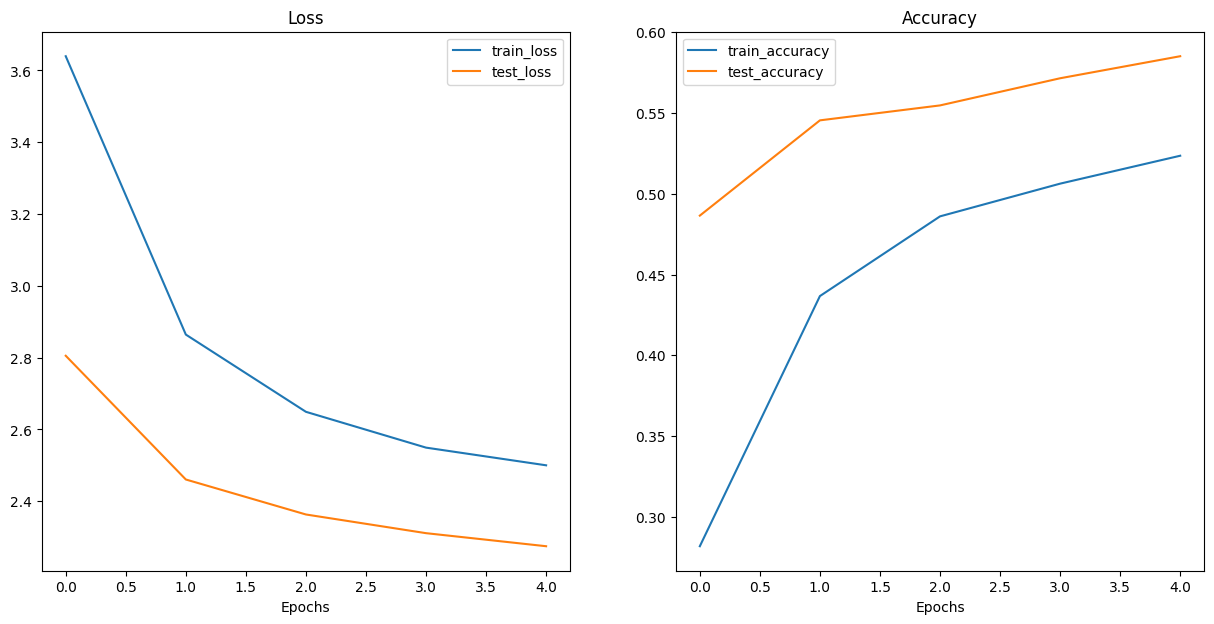

In [78]:
from helper_functions import plot_loss_curves
plot_loss_curves(food101_results)

### 10.7 Save and Load Food Vision Big

In [79]:
from going_modular.going_modular import utils

# create a model path
effnetb2_fod101_model_path = '09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth'

# save the food vision model
utils.save_model(model = effnet_b2_food101,
                 target_dir = 'models',
                 model_name = effnetb2_fod101_model_path)



[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth


In [80]:
# create Food101 compatible effnetb2 instance
loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# load the saved model state dict
loaded_effnetb2_food101.load_state_dict(torch.load(f = f'models/{effnetb2_fod101_model_path}'))

<All keys matched successfully>

### 10.8 Checking on our food vision big model size

In [81]:
from pathlib import Path

# finding out the model size
effnetb2_food101_size = Path('/content/models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth').stat().st_size / (1024 * 1024)
print(f'Our EffnetB2 food101 feature Extractor has a size of {effnetb2_food101_size:.1f} MB')

Our EffnetB2 food101 feature Extractor has a size of 30.4 MB


## 11 Turning our FoodVision Big into a Deployable App


Outline for our food vision big app:
```
demos/
  foodvision_big/
    09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth
    app.py
    class_names.txt
    examples/
      example_1.jpg
    model.py
    requirements.txt
```

In [82]:
from pathlib import Path

# create foodvision big demo path
foodvision_big_demo_path = Path('demos/foodvision_big')

# make foodvision big demo directory
foodvision_big_demo_path.mkdir(parents=True,
                                exist_ok=True)

# make foodvision big demo examples directory
(foodvision_big_demo_path / 'examples').mkdir(parents=True,
                                              exist_ok=True)

In [83]:
!ls demos/foodvision_big/

examples


### 11.1 Downloading an example image and moving it to the Examples directory

In [84]:
! # Download a custom image
import requests

# Setup custome image path
data_path = Path('data')
custom_image_path = data_path / '04-pizza-dad.jpeg'

# download image if doesn't exist
if not custom_image_path.is_file():
  with open(custom_image_path, 'wb') as f:
    # when downloading from github use the raw link
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/04-pizza-dad.jpeg?raw=true')
    print(f'Downloading {custom_image_path}')
    f.write(request.content)
else:
  print('File already exist')


In [85]:
!mv data/04-pizza-dad.jpeg demos/foodvision_big/examples/

In [86]:
!mv models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth demos/foodvision_big/

### 11.2 Saving the food classes into a txt file

In [87]:
with open('demos/foodvision_big/class_names.txt', 'w') as f:
  for name in food101_class_names:
    f.write(name+'\n')



In [88]:
# open food101 class names file and read each line into a list
with open('demos/foodvision_big/class_names.txt', 'r') as f:
  food101_class_names_loaded = [food.strip() for food in f.readlines()]

food101_class_names_loaded[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

### 11.3 Turning our Foodvision Big Model Into a python script

In [89]:
!cp demos/foodvision_mini/model.py demos/foodvision_big/

### 11.4 Turning Our foodvision big Gradio app into a python script

The file wit have four major parts
1. imports and class names, we'll import form class_names.txt
2. model and transforms preparation - make sure our model issuitable for Foodvision big
3. predict function `predict()`
4. gradio app -> our interface + launch command

In [90]:
%%writefile demos/foodvision_big/aap.py

### 1 imports and class names setup
import gradio as gr
import torch
import os

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# setup class names
with open('class_names.txt', 'r') as f:
  class_names = [food.strip for food in f.readlines()]

### 3. model and transform preparation
# create madel and tansforms
effnetb2, effentb2_transforms = create_effnetb2_model(num_classes=101)

# load the saved weights
effnetb2.load_state_dict(
    torch.load(f = '09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth',
               map_location=torch.device('cpu'))

)

### 3. Predict Function
def predict(img) -> Tuple[Dict, float]:
  # start a timer
  start_time = timer()

  # transform the input image
  transformed_img = effnetb2_transforms(img).unsqueeze(0).to('cpu')

  # Put model into eval mode, make prediciton
  effnetb2.eval()
  with torch.inference_mode():
    logits = effnetb2(transformed_img)
    pred_probs = torch.softmax(logits, dim=1)[0]

  # Create prediciton label and prediction probability dictionary
  pred_label_and_probs = {}
  for idx in range(len(class_names)):
    pred_label_and_probs[class_names[idx]] = float(pred_probs[idx])

  # calculate the pred time
  end_time = timer()
  pred_time = round(end_time - start_time, 4)

  # return pred dict and pred time

  return pred_label_and_probs, pred_time

### 4. Gradio App
# create title, description and article
title = 'Foodvision Big 🍔 👁️‍🗨️ 💪'
description = ' An EfficientNet computer vision model to classify images of 101 classes of food'
article = 'Created at 09. PyTorch Model Deployment'

example_list = [['examples/' + example] for example in os.listdir('examples')]

# create the gradio demo
demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type='pil'),
                    outputs=[gr.Label(num_top_classes=5, label = 'Predictions'),
                             gr.Number(label='Prediction Time (secs)')],
                    examples = example_list,
                    title=title,
                    description=description,
                    article=article)

# launch the demo
demo.launch(debug=False, # print errors locally
            share=True) # generate a publicly shareable URL



Writing demos/foodvision_big/aap.py


### 11.5 Creating a requirements file

In [92]:
%%writefile demos/foodvision_big/requirements.txt
torch==2.6.0
torchvision==0.21.0
gradio==5.27.0

Writing demos/foodvision_big/requirements.txt


### 11.6 Downloading our foodvision big app files

In [93]:
# change into the foodvision min directory and zip it rom the inside
!cd demos/foodvision_big && zip -r ../foodvision_big.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: 09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth (deflated 8%)
  adding: aap.py (deflated 53%)
  adding: class_names.txt (deflated 48%)
  adding: examples/ (stored 0%)
  adding: examples/04-pizza-dad.jpeg (deflated 0%)
  adding: model.py (deflated 50%)
  adding: requirements.txt (deflated 6%)


In [94]:
# download
try:
  from google.colab import files
  files.download('demos/foodvision_big.zip')
except:
  print('Not running in colab. Please download manually')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>